# **AI and the Future of Work and Learning**

## Objectives

Extract --> Transform --> load 
- File 1: linkedin_job_postings.csv
- File 2: job_skills.csv
- File 3: ai_automation_risk_dataset.csv

Working with 3 files from 2 seperate datsets from kaggle:
1. 1.3M LinkedIn Jobs & Skills 2024 Dataset
2. AI Automation Risk by Job Role Dataset

Due to the large size of the original LinkedIn dataset, a subset of the data was selected and used for this project to ensure manageable processing.

Hypothesis Testing 
- Hypothesis 1: Human-centred Skills and Automation Risk
- Hypothesis 2: Digital and Domain skills

Finally export cleaned, transformed data for PowerBI Dashboard. 

## Workflow

1. ETL (Extract → Transform → Load) - Clean Data 
2. EDA: Understand the Data 
3. Feature engineering: Build variables for Hypotheses
4. Hypothesis tests
5. ML prototype: A Simple Predictive Model

---

## Extract --> Transform --> Load 

Import Libraries

In [89]:
import pandas as pd # Convert to DataFrames
import numpy as np # Missing values + numeric processing 
import re # Clean text for better text matching = better joins = better analysis
import matplotlib.pyplot as plt # Plotting for EDA and results visualization
from scipy import stats #Statistical tests for hypothesis testing
import statsmodels.api as sm # Regression modeling and diagnostics

Read & Load the Data 

In [90]:
# Load the datasets
job_postings = pd.read_csv("../raw_data/linkedin_job_postings-trim.csv")
role_attrs = pd.read_csv("../raw_data/ai_automation_risk_dataset-trim.csv")

print("Loaded job_postings:", job_postings.shape)
print("Loaded role_attrs  :", role_attrs.shape)

Loaded job_postings: (50015, 14)
Loaded role_attrs  : (3000, 25)


Transform the Data 
- Clean Column Names 
- Normilisation 
- Mapping 
- Duplication 

In [91]:
job_postings["job_link"] = job_postings["job_link"].astype(str).str.strip() # job_link is unique posting identifier
role_attrs["job_role"] = role_attrs["job_role"].astype(str) 
job_postings["job_title"] = job_postings["job_title"].astype(str) # ensuring job_title and job_role are text

In [ ]:
# convert to lowercase, remove punctuation, and standardize whitespace for better text matching

job_postings["job_title_norm"] = (
    job_postings["job_title"]
    .str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s]+", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
)

role_attrs["job_role_norm"] = (
    role_attrs["job_role"]
    .str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s]+", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
)
# Merge on normalised text columns for better matching

In [ ]:
role_norm_to_role = dict(zip(role_attrs["job_role_norm"], role_attrs["job_role"]))
# map normalised role names back to original role names for interpretability

In [94]:
# substring matching function to handle cases where job titles include seniority/specialization words (e.g. "senior data analyst" should match "data analyst")

def map_role(title_norm):
    if title_norm in role_norm_to_role:
        return role_norm_to_role[title_norm]

    matches = [r for r in role_norm_to_role.keys() if r and r in title_norm]
    if len(matches) > 0:
        best_match = max(matches, key=len)
        return role_norm_to_role[best_match]

    return np.nan

In [ ]:
# apply mapping function to each posting’s normalized title

job_postings["job_role_mapped"] = job_postings["job_title_norm"].apply(map_role)
match_rate = job_postings["job_role_mapped"].notna().mean()

print(f"Role mapping match rate: {match_rate:.1%}")

Role mapping match rate: 14.4%


In [ ]:
# now we have a mapped role for each posting (where possible), we can merge the datasets to bring in the role attributes for analysis

df = job_postings.merge(
    role_attrs.add_prefix("role__"),
    left_on="job_role_mapped",
    right_on="role__job_role",
    how="left"
)

print("Joined dataset shape:", df.shape)

Joined dataset shape: (1125625, 42)


In [ ]:
# ensure each row is a unique job posting. 
# we’ll drop duplicates based on the job_link, which should uniquely identify each posting. 

df_posting = (
    df.sort_values("job_link")
    .drop_duplicates("job_link")
    .reset_index(drop=True)
)

print("Rows after dedupe:", len(df_posting))
print("Unique job_links :", df_posting["job_link"].nunique())


Rows after dedupe: 50015
Unique job_links : 50015


## Feature Engineering 

In [ ]:
# convert columns we want to analyze to numeric, coercing errors to NaN 

df_posting["automation_risk_score"] = pd.to_numeric(df_posting["role__automation_risk_score"], errors="coerce")
df_posting["job_growth_rate"] = pd.to_numeric(df_posting["role__job_growth_rate"], errors="coerce")
df_posting["task_repetition_level"] = pd.to_numeric(df_posting["role__task_repetition_level"], errors="coerce")
df_posting["domain_level"] = pd.to_numeric(df_posting["role__domain_specific_knowledge_level"], errors="coerce")
df_posting["ai_dependency"] = pd.to_numeric(df_posting["role__ai_dependency_current"], errors="coerce")

In [ ]:
# convert the human-centred skill columns to numeric

human_cols = [
    "role__communication_requirement",
    "role__social_interaction_level",
    "role__team_collaboration_level",
    "role__creativity_requirement"
]
for c in human_cols:
    df_posting[c] = pd.to_numeric(df_posting[c], errors="coerce")

In [ ]:
# scaling the human-centred skill components so they’re on the same 0-1 scale before averaging them into a composite index

for c in human_cols:
    col_min = df_posting[c].min()
    col_max = df_posting[c].max()

    if pd.notna(col_min) and pd.notna(col_max) and col_min != col_max:
        df_posting[c + "_scaled"] = (df_posting[c] - col_min) / (col_max - col_min)
    else:
        df_posting[c + "_scaled"] = np.nan

In [ ]:
# create the human-centred skills index by averaging the scaled components

df_posting["human_centred_index"] = df_posting[[c + "_scaled" for c in human_cols]].mean(axis=1)

## Exploratory Data Analysis

Distribution

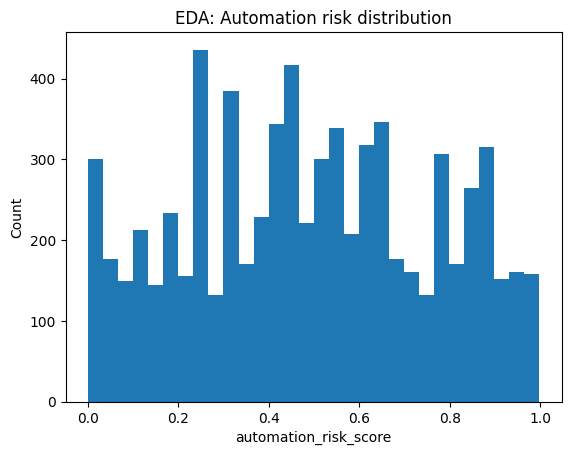

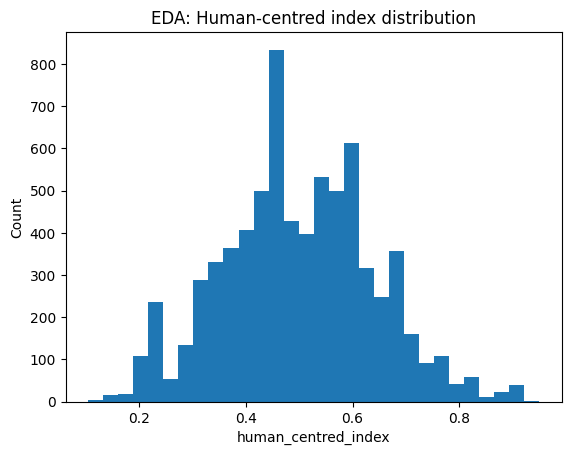

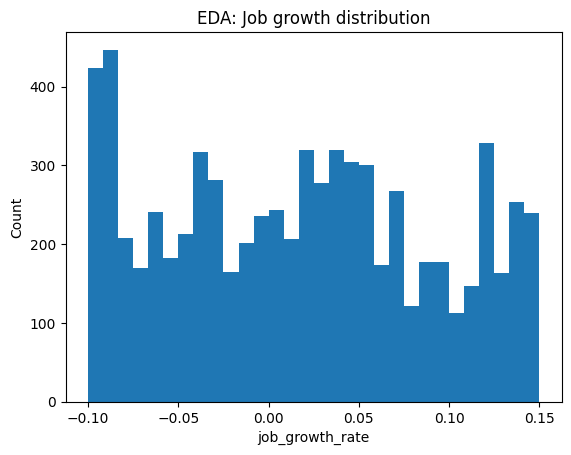

In [ ]:
for col, title in [
    ("automation_risk_score", "EDA: Automation risk distribution"),
    ("human_centred_index", "EDA: Human-centred index distribution"),
    ("job_growth_rate", "EDA: Job growth distribution")
]:
    s = df_posting[col].dropna()
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(title); plt.xlabel(col); plt.ylabel("Count")
    plt.show()

Descriptive Statistics
- count
- mean
- std
- min
- 25%, 50%, 75%
- max

In [104]:
df_posting[
    ["automation_risk_score", "human_centred_index", "job_growth_rate"]
].describe()

,automation_risk_score,human_centred_index,job_growth_rate
count,7215.000000,7215.000000,7215.000000
mean,0.491497,0.498504,0.016578
std,0.268652,0.141405,0.073386
min,0.000739,0.104962,-0.099897
25%,0.263281,0.407729,-0.045716
50%,0.486839,0.492405,0.017581
75%,0.700187,0.588832,0.071948
max,0.997805,0.949171,0.149902


## Hypothesis Testing 

Hypothesis 1:

Jobs that require more human-centred skills (communication, teamwork, social interaction and creativity) are less likely to be automated.


H1a: More human skills → lower automation risk.

In [ ]:
# this gives us the mean, std, min, max, and quartiles for our key numeric variables, which helps us understand their central tendency and spread before we run our regression models.
h1a_df = df_posting.dropna(subset=["automation_risk_score", "human_centred_index"]).copy()
X = sm.add_constant(h1a_df["human_centred_index"])
y = h1a_df["automation_risk_score"]

model_h1a = sm.OLS(y, X).fit()

print("\nH1a: automation_risk_score ~ human_centred_index")
print(model_h1a.summary())



H1a: automation_risk_score ~ human_centred_index
                              OLS Regression Results                             
Dep. Variable:     automation_risk_score   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.004
Method:                    Least Squares   F-statistic:                     29.77
Date:                   Thu, 12 Feb 2026   Prob (F-statistic):           5.02e-08
Time:                           14:46:38   Log-Likelihood:                -739.33
No. Observations:                   7215   AIC:                             1483.
Df Residuals:                       7213   BIC:                             1496.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

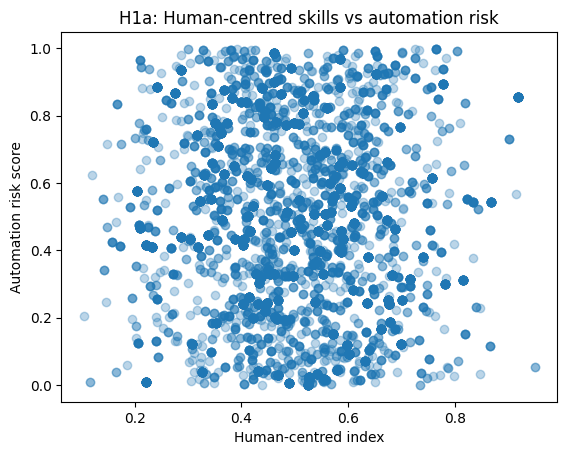

In [ ]:
# Visual
plt.figure()
plt.scatter(h1a_df["human_centred_index"], h1a_df["automation_risk_score"], alpha=0.3)

plt.xlabel("Human-centred index"); plt.ylabel("Automation risk score")
plt.title("H1a: Human-centred skills vs automation risk")
plt.show()

H1b: Repetitive tasks → HIGHER automation risk

In [ ]:
# repeat the process for H1b, testing whether task repetition level predicts automation risk
h1b_df = df_posting.dropna(subset=["automation_risk_score", "task_repetition_level"]).copy()
X = sm.add_constant(h1b_df["task_repetition_level"])
y = h1b_df["automation_risk_score"]

model_h1b = sm.OLS(y, X).fit()

print("\nH1b: automation_risk_score ~ task_repetition_level")
print(model_h1b.summary())


H1b: automation_risk_score ~ task_repetition_level
                              OLS Regression Results                             
Dep. Variable:     automation_risk_score   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                   0.04758
Date:                   Thu, 12 Feb 2026   Prob (F-statistic):              0.827
Time:                           14:46:45   Log-Likelihood:                -754.17
No. Observations:                   7215   AIC:                             1512.
Df Residuals:                       7213   BIC:                             1526.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

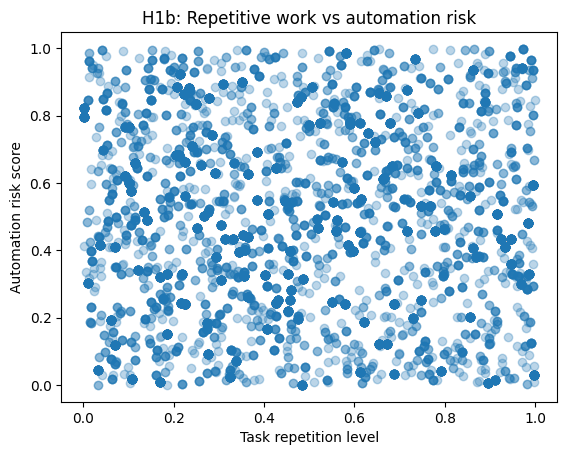

In [ ]:
#Visual
plt.figure()
plt.scatter(h1b_df["task_repetition_level"], h1b_df["automation_risk_score"], alpha=0.3)
plt.xlabel("Task repetition level")
plt.ylabel("Automation risk score")
plt.title("H1b: Repetitive work vs automation risk")
plt.show()

Hypothesis 2:

Job roles that combine digital or AI skills with domain knowledge (such as healthcare, business, education or engineering) are growing faster than roles that require only technical skills or only non-technical skills.

Build Groups for H2a/H2b (role-level)


In [ ]:
# look at the role-level attributes by grouping the postings by their mapped role and taking the first non-null value for each attribute

role_level = (
    df_posting
      .dropna(subset=["job_role_mapped", "domain_level", "ai_dependency"])
      .groupby("job_role_mapped", as_index=False)
      .agg(
          domain_level=("domain_level", "first"),
          ai_dependency=("ai_dependency", "first"),
          automation_risk_score=("automation_risk_score", "first"),
          job_growth_rate=("job_growth_rate", "first")
      )
)

In [ ]:
# create thresholds for medium
domain_thr = role_level["domain_level"].median()
ai_thr = role_level["ai_dependency"].median()

high_domain = role_level["domain_level"] >= domain_thr
high_ai = role_level["ai_dependency"] >= ai_thr


In [ ]:
# define groups based on high/low domain and AI levels
role_level["skill_group"] = np.select(
    [high_ai & (~high_domain), high_ai & high_domain],
    ["Technical-only", "Tech+Domain"],
    default=np.nan
)

role_2g = role_level.dropna(subset=["skill_group"]).copy()

print("\nRole counts by group:")
print(role_2g["skill_group"].value_counts())



Role counts by group:
skill_group
nan               10
Technical-only     6
Tech+Domain        4
Name: count, dtype: int64


H2a: Tech+Domain LOWER automation risk than Technical-only 

In [ ]:
# extract the automation risk scores for each group to prepare for the t-test comparing the two groups on their automation risk scores
h2a_df = role_2g.dropna(subset=["automation_risk_score"]).copy()

tech_domain_risk = h2a_df.loc[h2a_df["skill_group"]=="Tech+Domain", "automation_risk_score"].values
technical_only_risk = h2a_df.loc[h2a_df["skill_group"]=="Technical-only", "automation_risk_score"].values


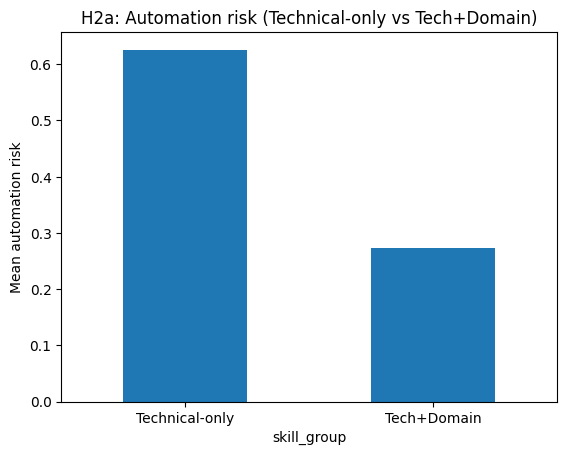

In [ ]:
# visual
means = h2a_df.groupby("skill_group")["automation_risk_score"].mean().reindex(["Technical-only", "Tech+Domain"])

plt.figure()
means.plot(kind="bar")
plt.ylabel("Mean automation risk")
plt.title("H2a: Automation risk (Technical-only vs Tech+Domain)")
plt.xticks(rotation=0)
plt.show()

In [105]:
t_stat, p_two = stats.ttest_ind(tech_domain_risk, technical_only_risk, equal_var=False)

if np.nanmean(tech_domain_risk) < np.nanmean(technical_only_risk):
    p_one = p_two / 2
else:
    p_one = 1 - (p_two / 2)
print(f"H2a t-statistic: {t_stat:.3f}, two-sided p-value: {p_two:.3f}, one-sided p-value: {p_one:.3f}")

H2a t-statistic: -2.237, two-sided p-value: 0.072, one-sided p-value: 0.036


In [75]:
print("\nH2a results:")
print("Mean risk Tech+Domain   :", np.nanmean(tech_domain_risk))
print("Mean risk Technical-only:", np.nanmean(technical_only_risk))
print(f"T-test (Tech+Domain < Technical-only): t={t_stat:.4f}, one-sided p={p_fmt(p_one)}")


H2a results:
Mean risk Tech+Domain   : 0.2730926636130051
Mean risk Technical-only: 0.6260818054866729
T-test (Tech+Domain < Technical-only): t=-2.2369, one-sided p=0.036


H2b: Tech+Domain HIGHER job growth than Technical-only

In [76]:
h2b_df = role_2g.dropna(subset=["job_growth_rate"]).copy()

tech_domain_growth = h2b_df.loc[h2b_df["skill_group"]=="Tech+Domain", "job_growth_rate"].values
technical_only_growth = h2b_df.loc[h2b_df["skill_group"]=="Technical-only", "job_growth_rate"].values

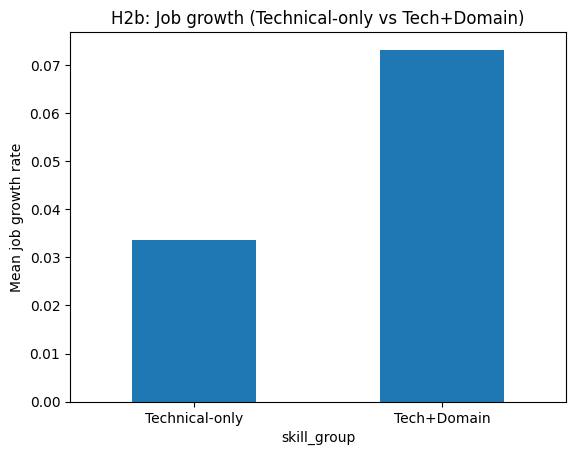

In [ ]:
# visual
means_g = h2b_df.groupby("skill_group")["job_growth_rate"].mean().reindex(["Technical-only", "Tech+Domain"])
plt.figure()
means_g.plot(kind="bar")
plt.ylabel("Mean job growth rate")
plt.title("H2b: Job growth (Technical-only vs Tech+Domain)")
plt.xticks(rotation=0)
plt.show()

In [ ]:
#t-test for H2b
t_stat, p_two = stats.ttest_ind(tech_domain_growth, technical_only_growth, equal_var=False)

if np.nanmean(tech_domain_growth) > np.nanmean(technical_only_growth):
    p_one = p_two / 2
else:
    p_one = 1 - (p_two / 2)

print("\nH2b results:")
print("Mean growth Tech+Domain   :", np.nanmean(tech_domain_growth))
print("Mean growth Technical-only:", np.nanmean(technical_only_growth))
print(f"T-test (Tech+Domain > Technical-only): t={t_stat:.4f}, one-sided p={p_fmt(p_one)}")


H2b results:
Mean growth Tech+Domain   : 0.07321859037002573
Mean growth Technical-only: 0.033649532560767755
T-test (Tech+Domain > Technical-only): t=0.5808, one-sided p=0.292


ML Prototype (Predictive Demo)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


Prepare Dataset

In [ ]:
ml_df = df_posting.dropna(subset=["automation_risk_score", "human_centred_index", "domain_level", "ai_dependency"]).copy()
X = ml_df[["human_centred_index", "domain_level", "ai_dependency"]]
y = ml_df["automation_risk_score"]

Train/Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fit + Predict

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

Evaluate

In [ ]:
r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print("\nML Prototype results:")
print("R^2 :", round(r2, 3))
print("RMSE:", round(rmse, 3))


ML Prototype results:
R^2 : 0.01
RMSE: 0.266


Visual Actual vs Predicted

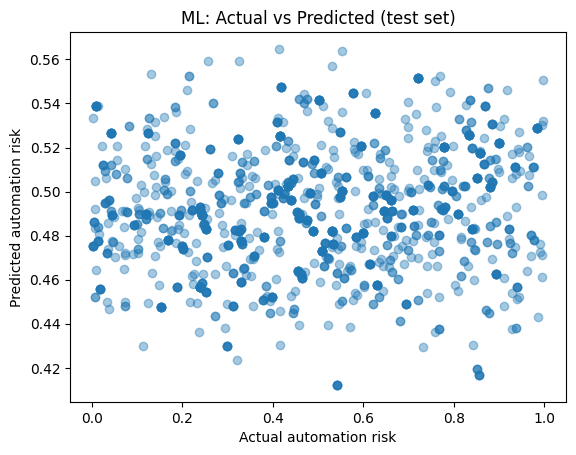

In [84]:
plt.figure()
plt.scatter(y_test, pred, alpha=0.4)
plt.xlabel("Actual automation risk")
plt.ylabel("Predicted automation risk")
plt.title("ML: Actual vs Predicted (test set)")
plt.show()

Export Dashboard File 

In [ ]:

import os
import pandas as pd

processed_dir = "../processed"
os.makedirs(processed_dir, exist_ok=True)

export_cols = [
    # identifiers
    "job_link",
    "job_title",
    "job_role_mapped",

    # H1 visuals
    "human_centred_index",
    "task_repetition_level",
    "automation_risk_score",

    # H2 visuals
    "job_growth_rate",
    "domain_level",
    "ai_dependency"
]

# keep only columns that exist
export_cols = [c for c in export_cols if c in df_posting.columns]
powerbi_df = df_posting[export_cols].copy()

# ensure numeric columns are numeric 
num_cols = [
    "human_centred_index",
    "task_repetition_level",
    "automation_risk_score",
    "job_growth_rate",
    "domain_level",
    "ai_dependency"
]

for c in num_cols:
    if c in powerbi_df.columns:
        powerbi_df[c] = pd.to_numeric(powerbi_df[c], errors="coerce")

output_path = os.path.join(processed_dir, "powerbi_dashboard.csv")
powerbi_df.to_csv(output_path, index=False, encoding="utf-8")

print("Exported:", output_path)
print("Rows:", len(powerbi_df))

✅ Exported: ../processed\powerbi_dashboard.csv
Rows: 50015
